Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Forests of randomized trees

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

from sklearn.utils import resample

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [3]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col='rgiid')
df_main.columns

Index(['Unnamed: 0', 'x', 'y', 'Surge', 'Area', 'Slope', 'TermType', 'Name',
       'bed', 'thickness', 'surface_elevation', 'ELA', 'beta', 'cmb',
       'width_centerline', 'Runoff'],
      dtype='object')

In [4]:
df_main.shape

(94234, 16)

In [5]:
df_main['WH'] = df_main['width_centerline'] / df_main['thickness']
df_main['WHsin'] = df_main['thickness']*df_main['width_centerline']*np.sin(df_main['Slope'])
df_main['dummy'] = np.random.rand(df_main.shape[0])

In [6]:
df_main.drop(df_main[df_main['Surge']==9].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==1].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==2].index, inplace = True)
df = df_main.drop(columns = ['Unnamed: 0','x', 'y', 'ELA', 'beta', 'Name', 'Area'])
df.dropna(how='any', inplace=True)

In [7]:
df

,Surge,Slope,TermType,bed,thickness,surface_elevation,cmb,width_centerline,Runoff,WH,WHsin,dummy
rgiid,,,,,,,,,,,,
RGI60-07.00004,0,13.8,0,889.68555,25.314478,915.00000,1.392706,279.780932,1.100061,11.052210,6683.732353,0.865116
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.391001,295.980219,1.094416,9.567670,8640.744376,0.213691
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.389296,330.851846,1.088771,10.694908,9658.774620,0.578530
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.387591,342.886985,1.083127,11.083948,10010.124318,0.660407
RGI60-07.00004,0,13.8,0,881.31860,34.681380,916.00000,1.385886,336.403639,1.077530,9.699834,11010.043050,0.050801
...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01567,3,11.7,0,237.64468,50.380424,288.02512,-1.412920,278.553621,2.123592,5.529005,-10693.410549,0.031862
RGI60-07.01567,3,11.7,0,233.07228,46.717087,279.78937,-1.423469,256.755923,2.127417,5.495975,-9139.908345,0.831731
RGI60-07.01567,3,11.7,0,233.07228,46.717087,279.78937,-1.395654,238.477978,2.076787,5.104727,-8489.256385,0.635407


In [8]:
df_main.groupby('Surge').count()

,Unnamed: 0,x,y,Area,Slope,TermType,Name,bed,thickness,surface_elevation,ELA,beta,cmb,width_centerline,Runoff,WH,WHsin,dummy
Surge,,,,,,,,,,,,,,,,,,
0,68813,68813,68813,68813,68813,68813,48314,68813,68813,68813,68752,68752,68752,68707,68813,68707,68707,68813
3,10906,10906,10906,10906,10906,10906,10827,10906,10906,10906,10897,10897,10897,10905,10906,10905,10905,10906


In [9]:
df['Surge'] = df['Surge'].replace({3: 1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    68675
1    10897
Name: label, dtype: int64

In [10]:
df[df['label']==1].shape[0]

10897

In [11]:
df.shape

(79572, 12)

### Resampled

In [12]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [13]:
df_downsampled.columns

Index(['label', 'Slope', 'TermType', 'bed', 'thickness', 'surface_elevation',
       'cmb', 'width_centerline', 'Runoff', 'WH', 'WHsin', 'dummy'],
      dtype='object')

In [14]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [15]:
train_labels.sum()/train_labels.shape[0]

0.5000327761389708

In [16]:
test_labels.sum()/test_labels.shape[0]

0.499923535708824

In [17]:
missing_data = df.isna()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

Slope
False    21794
Name: Slope, dtype: int64

TermType
False    21794
Name: TermType, dtype: int64

bed
False    21794
Name: bed, dtype: int64

thickness
False    21794
Name: thickness, dtype: int64

surface_elevation
False    21794
Name: surface_elevation, dtype: int64

cmb
False    21794
Name: cmb, dtype: int64

width_centerline
False    21794
Name: width_centerline, dtype: int64

Runoff
False    21794
Name: Runoff, dtype: int64

WH
False    21794
Name: WH, dtype: int64

WHsin
False    21794
Name: WHsin, dtype: int64

dummy
False    21794
Name: dummy, dtype: int64



In [18]:
4081/81683

0.04996143628417174

In [19]:
# Features for feature importances
features = list(train.columns)
features

['Slope',
 'TermType',
 'bed',
 'thickness',
 'surface_elevation',
 'cmb',
 'width_centerline',
 'Runoff',
 'WH',
 'WHsin',
 'dummy']

In [20]:
train.shape

(15255, 11)

In [21]:
train_labels.shape

(15255,)

In [22]:
test.shape

(6539, 11)

### Evaluate the decision tree

In [23]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'k', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'm', label = 'model')
    plt.text(s = 'AUC = ' + str(round(roc_auc_score(train_labels, train_probs),2))
    , x=0.6, y=0.0, fontsize=15
)
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

### Random forest

In [47]:
df.shape

(21794, 11)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [43]:
np.arange(200, 2200, 200)

array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000])

In [48]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(200, 2200, 200)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(1, 5, 1)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [49]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_cv = GridSearchCV(rf, random_grid, cv = 3, verbose=2, n_jobs = -1)

In [50]:
# Fit the random search model
rf_cv.fit(train, train_labels)
print("tuned hpyerparameters :(best parameters) ",rf_cv.best_params_)
print("accuracy :",rf_cv.best_score_)

Fitting 3 folds for each of 1800 candidates, totalling 5400 fits


/home/colili/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


tuned hpyerparameters :(best parameters)  {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
accuracy : 0.9627007538511964


In [ ]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=1000, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               max_depth = 2,
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

In [25]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 7
Average maximum depth 2


In [26]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Paral

In [27]:
pd.DataFrame({'true':test_labels, 'predictions':rf_predictions, 'probs':rf_probs}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/ROC_curve/df_compare_roc_RF_centerline_resample_area.csv')

Recall Baseline: 1.0 Test: 0.71 Train: 0.7
Precision Baseline: 0.5 Test: 0.75 Train: 0.75
Roc Baseline: 0.5 Test: 0.8 Train: 0.8


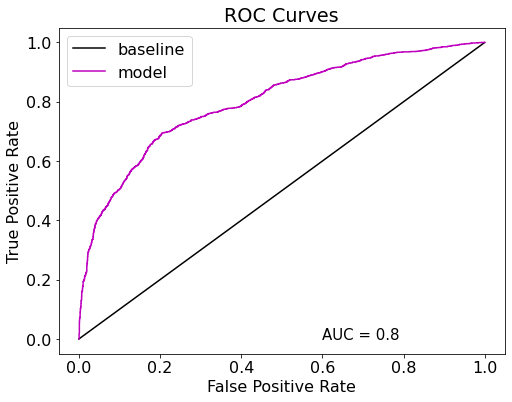

In [28]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    cbar = plt.colorbar(aspect=4)
    plt.clim(0,100)
    cbar.set_label('Fraction (%)')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[38 12]
 [15 35]]


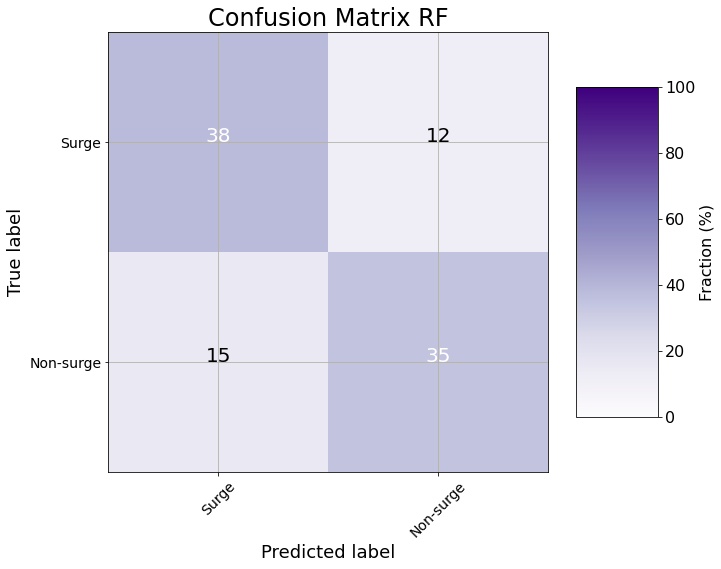

In [30]:
cm_rf = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(np.round(cm_rf/(test_labels.shape)*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix RF', cmap='Purples')

In [31]:
from sklearn.metrics import average_precision_score
average_precision_rf = average_precision_score(test_labels, rf_predictions)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_rf))

Average precision-recall score: 0.68


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Text(0.5, 1.0, '2-class Precision-Recall curve RF: AP=0.68')

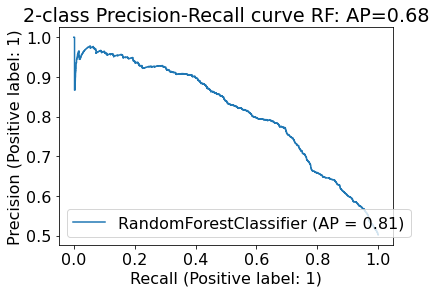

In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp_rf = plot_precision_recall_curve(model, test, test_labels)
disp_rf.ax_.set_title('2-class Precision-Recall curve RF: '
                   'AP={0:0.2f}'.format(average_precision_rf))

In [33]:
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 1445 nodes with maximum depth 26.


In [34]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
0,Slope,0.453117
5,cmb,0.167018
6,width_centerline,0.077448
7,Runoff,0.059062
2,bed,0.056179


# Gradient boosting

In [35]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [36]:
# dmatrix_train = xgboost.DMatrix(train[train.columns[1:]], label=train_labels)
# dmatrix_test = xgboost.DMatrix(test[test.columns[1:]], label=test_labels)

dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test, label=test_labels)

In [37]:
train_labels

array([1, 0, 0, ..., 0, 0, 1])

In [38]:
test_labels

array([1, 0, 0, ..., 0, 0, 0])

In [39]:
trainprob = train.copy()
trainprob['y'] = train_labels

trainprob.corr()

,Slope,TermType,bed,thickness,surface_elevation,cmb,width_centerline,Runoff,WH,WHsin,dummy,y
Slope,1.000000,-0.268806,0.436993,-0.531408,0.264753,0.152873,-0.355296,-0.180692,-0.091803,0.112600,-0.006248,-0.407064
TermType,-0.268806,1.000000,-0.316771,0.376568,-0.195513,0.045584,0.226940,0.187502,0.033846,-0.131927,0.006719,0.307612
bed,0.436993,-0.316771,1.000000,-0.442591,0.927752,-0.199035,-0.205606,-0.648754,0.034408,0.080649,-0.008748,-0.287526
thickness,-0.531408,0.376568,-0.442591,1.000000,-0.075959,-0.183073,0.365110,0.033617,-0.047945,-0.235068,0.002874,0.325232
surface_elevation,0.264753,-0.195513,0.927752,-0.075959,1.000000,-0.297508,-0.076672,-0.707391,0.018306,-0.008153,-0.008532,-0.184359
cmb,0.152873,0.045584,-0.199035,-0.183073,-0.297508,1.000000,-0.250112,0.470894,-0.135725,0.229400,-0.004739,-0.004177
width_centerline,-0.355296,0.226940,-0.205606,0.365110,-0.076672,-0.250112,1.000000,-0.048355,0.645546,-0.594876,-0.000449,0.194559
Runoff,-0.180692,0.187502,-0.648754,0.033617,-0.707391,0.470894,-0.048355,1.000000,-0.051397,0.125854,0.008970,0.207907
WH,-0.091803,0.033846,0.034408,-0.047945,0.018306,-0.135725,0.645546,-0.051397,1.000000,-0.265646,0.001398,0.047362
WHsin,0.112600,-0.131927,0.080649,-0.235068,-0.008153,0.229400,-0.594876,0.125854,-0.265646,1.000000,-0.013869,-0.067655


In [40]:
# trainprob.Area.hist(bins=100)

In [41]:
# trainprob[trainprob.y==0].Area.describe()

In [42]:
# trainprob[trainprob.y==1].Area.describe()

In [43]:
params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.5}

xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

[16:26:22] WARNING: ../src/learner.cc:541: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [44]:
predictions_xgboost = xgb.predict(dmatrix_test)
pd.DataFrame({'true':test_labels, 'predictions':predictions_xgboost})
pd.DataFrame({'true':test_labels, 'predictions':predictions_xgboost}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/ROC_curve/df_compare_roc_xgboost_centerline_resample_area.csv')

Text(0.6, 0.0, 'AUC = 0.92')

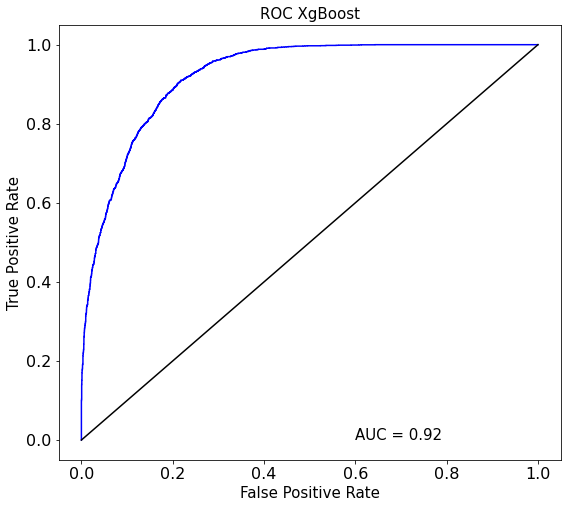

In [45]:
fpr, tpr, t = metrics.roc_curve(y_true=test_labels, y_score=predictions_xgboost)

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr, 'b')
ax.plot([0, 1], [0, 1], 'k')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('ROC XgBoost', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=test_labels, y_score=predictions_xgboost),2))
    , x=0.6, y=0.0, fontsize=15
)

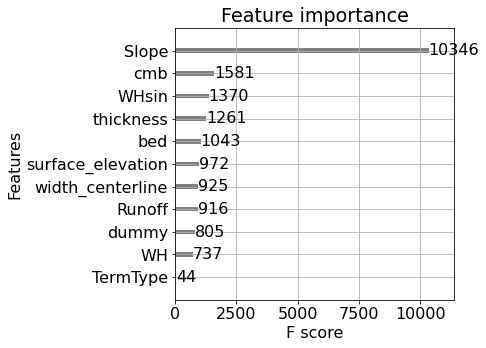

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, ax=ax, color='grey')

In [47]:
average_precision_xgboost = average_precision_score(test_labels, predictions_xgboost)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_xgboost))

Average precision-recall score: 0.92


In [48]:
test_labels.dtype

dtype('int64')

Confusion matrix, without normalization
[[44  5]
 [11 38]]


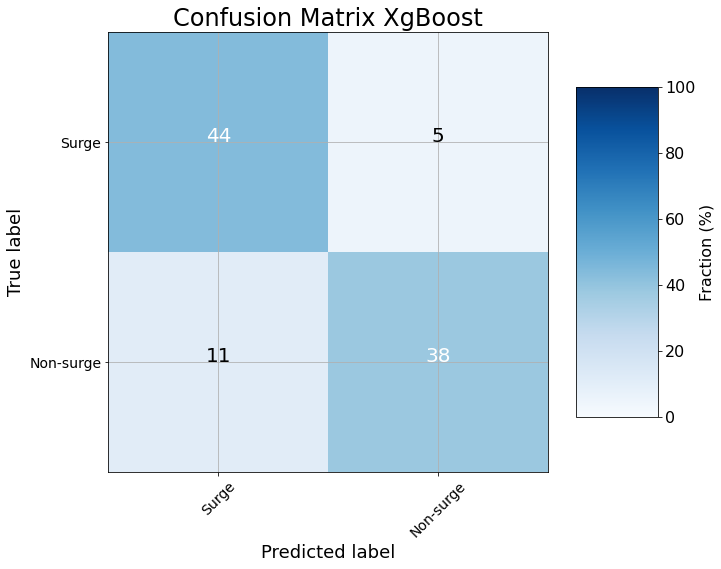

In [49]:
# confusion_matrix(test_labels, predictions.round())
cm_xgboost = confusion_matrix(test_labels, predictions_xgboost.round())
plot_confusion_matrix((cm_xgboost/test_labels.shape*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix XgBoost', cmap='Blues')

Theory: https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148

Example: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

# Logistic regression

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
logreg = LogisticRegression()
logreg.fit(train, train_labels)

LogisticRegression()

In [52]:
predictions_LR = logreg.predict(test)
probs_LR = logreg.predict_proba(test)[:, 1]
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test, test_labels)))

Accuracy of logistic regression classifier on test set: 0.69


In [53]:
test_labels.sum()

3269

In [54]:
pd.DataFrame({'true':test_labels, 'predictions':predictions_LR, 'prob':probs_LR}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/ROC_curve/df_compare_roc_LR_centerline_resample_area.csv')

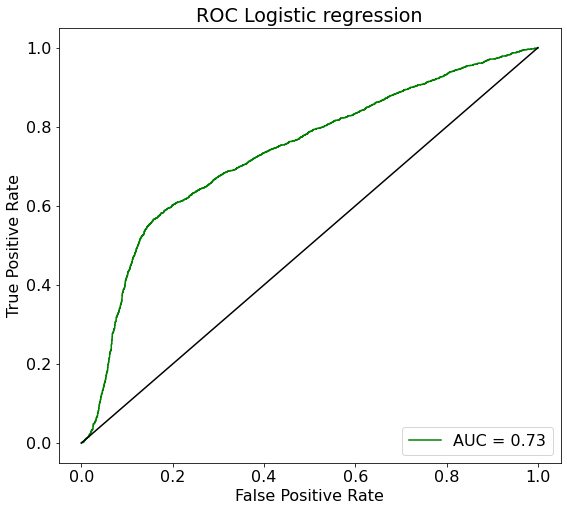

In [55]:
logit_roc_auc = roc_auc_score(test_labels, logreg.predict_proba(test)[:,1])
fpr, tpr, thresholds = roc_curve(test_labels, logreg.predict_proba(test)[:,1])
plt.figure(figsize=(9, 8))
plt.plot(fpr, tpr, 'g', label='AUC = %0.2f' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k')
# # plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Logistic regression')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

<function confusion_matrix at 0x7ff3ef8cdaf0>
Confusion matrix, without normalization
[[35 14]
 [16 33]]


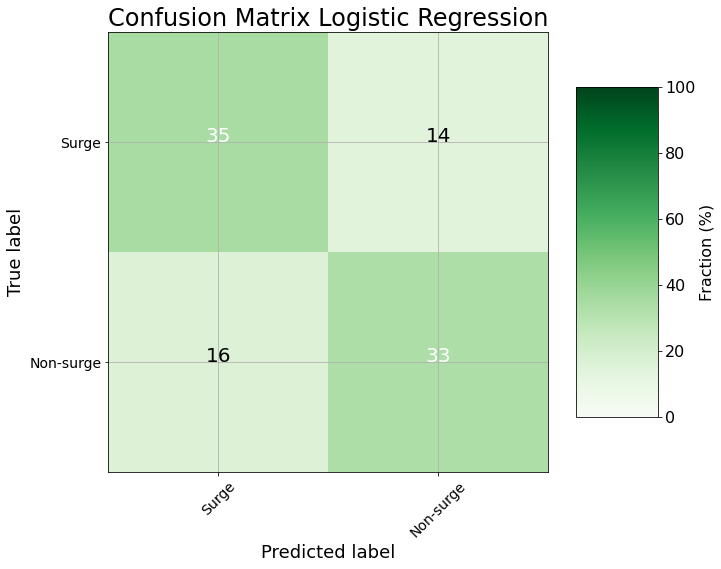

In [56]:
from sklearn.metrics import confusion_matrix
cm_LR = confusion_matrix(test_labels, predictions_LR)
print(confusion_matrix)
plot_confusion_matrix((cm_LR/test_labels.shape*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix Logistic Regression', cmap='Greens')

In [57]:
average_precision_LR = average_precision_score(test_labels, predictions_LR)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_LR))

Average precision-recall score: 0.63


Text(0.5, 1.0, '2-class Precision-Recall curve RF: AP=0.63')

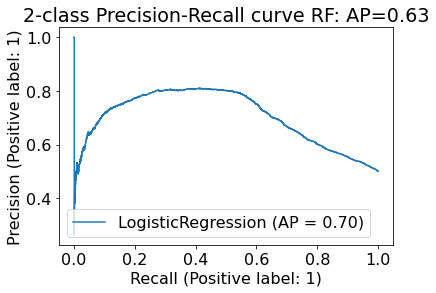

In [58]:
disp_lr = plot_precision_recall_curve(logreg, test, test_labels)
disp_lr.ax_.set_title('2-class Precision-Recall curve RF: '
                   'AP={0:0.2f}'.format(average_precision_LR))